In [0]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
np.set_printoptions(precision=4)

In [0]:
BIG_WIDTH = 3072 # Ширина большого изображения (пиксели)

# typical Other settings \ Типичные значения параметров
settings = [17, 0.5, 62, 5, 64, 200]

base = settings[0] # Длина базы (метры)
base_err = settings[1] # Ошибка длины базы (метры)
viewangle_x = settings[2] # in degrees \ Угол обзора камеры (градусы)
viewangle_x_err = settings[3] # in degrees \ Ошибка угла обзора (градусы)
num_shades = int(settings[4]) # Количество градаций серого (максимум 256) для изображений
min_height = settings[5] # Априорно известная минимальная высота облака (метры)

resolution_x = BIG_WIDTH; # Разрешение кадра по оси Х
viewangle = np.pi * viewangle_x / 180.0 # Угол обзора камеры (радианы)

In [0]:
# g === area (big image) -- from RIGHT img (#2) \ g - Область поиска на ПРАВОМ кадре
# f === fragment -- from LEFT img (#1) \ f - Фрагмент с ЛЕВОГО кадра
date = "20160825-143207-156" # Дата съемки (часть имени файла)

# Открываем съюстированные изображения
f = Image.open("img/" + date + "-1_aff_applied.jpg").convert('L')
g = Image.open("img/" + date + "-2_aff_applied.jpg").convert('L')

# Конвертируем изображения в Grayscale
f = f.convert("P", palette=Image.ADAPTIVE, colors=num_shades)
g = g.convert("P", palette=Image.ADAPTIVE, colors=num_shades)

# Get fragment from left image \ Размеры фрагмента "f"
wf = 150
hf = 150

# Координаты лев верх угла фрагмента
xf = np.random.randint(f.width / 4.0, 3 * f.width / 4.0)
yf = np.random.randint(f.height / 4.0, 3 * f.height / 4.0)

# Оставляем только фрагмент из левого изображения
crop_box = (xf, yf, xf + wf, yf + hf)
f = f.crop(crop_box)


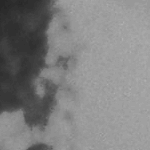

In [0]:
# Create matrix of fragment \ Яркости фрагмента записываем в матрицу
f_mat = np.asarray(f.getdata(), dtype=np.int).reshape(f.size[1], f.size[0])
Image.fromarray((f_mat * 256 / num_shades).astype('uint8'), 'L') # Рисуем фрагмент

(150, 150)
963 2093


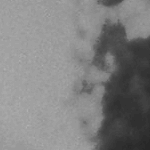

In [0]:
# Flip matrix \ Переворачиваем матрицу фрагмента (нужно для БПФ)
f_mat = np.fliplr(f_mat)
f_mat = np.flipud(f_mat)

print (f.size)
print (yf, xf)
Image.fromarray((f_mat * 256 / num_shades).astype('uint8'), 'L')

In [0]:
# g === area (big image) -- from RIGHT img (#2)
# f === fragment -- from LEFT img (#1)


# mpd is Maximum Pixel Distance <--> Minimum cloud height(altitude) 
# Максимальная дистанция (пикс) между фрагментами. Связана с минимальной высотой облака
mpd = base * resolution_x / (2 * np.tan(viewangle / 2.0) * min_height)
fac_x = 1; # reserve-coefficient \ Коэффициент запаса по оси Х
fac_y = 1.5; #reserve-coefficient \ \ Коэффициент запаса по оси Y

# Координаты лев верх угла области поиска "g" с ПРАВОГО изображения
area_x = int(xf - fac_x * wf)
area_y = int(yf - fac_y * hf)
# Ширина и высота области поиска "g" с ПРАВОГО изображения
area_width = int(mpd + 2 * fac_x * wf)
area_height = int(2 * fac_y * hf)
print (area_x, area_y)
print (area_width, area_height)

# area to search on right image \ С правого изображения оставляем только область поиска "g"
g = g.crop( (area_x, area_y, 
                        area_x + area_width, area_y + area_height) ) 

wg = area_width
hg = area_height
xg = area_x
yg = area_y

1943 738
517 450


In [0]:
print (g.size)
# Записываем значения яркостей изображения "g" в матрицу
g_mat = np.asarray(g.getdata(), dtype=np.int).reshape(g.size[1], g.size[0])

(517, 450)


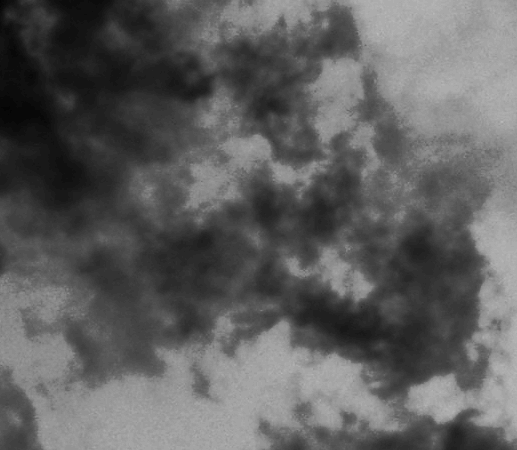

In [0]:
Image.fromarray((g_mat * 256 / num_shades).astype('uint8'), 'L') # Рисуем "g"

In [0]:
# Seacrh algo here \ Здесь начинается алгоритм поиска

In [0]:
# Create indicators of f \ Создаем индикаторные функции "хи"
# of size == g.size \ Размеры: число градаций серого * размеры области поиска "g"
chi = np.zeros((num_shades, g.size[1], g.size[0]), dtype=bool)

In [0]:
# fill the indicators \ Заполняем индикаторные функции
for h in range(f.size[1]):
    for w in range(f.size[0]):
        color = f_mat[h, w]
        chi[color, h, w] = True

In [0]:
# chi_elems[i] === number of pixels that have color "i" \ Гистограмма яркости пикселей фрагмента "f"
chi_elems = np.array( f.histogram() )

In [0]:
fft_chi = np.fft.fft2(chi) # Прямое 2D БПФ от инд. функций "хи"

In [0]:
fft_g = np.fft.fft2(g_mat) # Прямое 2D БПФ от матрицы пикселей области "g"

In [0]:
# Scalar product (g_frag, chi[i]) 
sp_g_frag_chi = np.zeros((num_shades, g.size[1] - hf, g.size[0] - wf))

# Вычисляем скалярные произведения (g_frag * chi[i]) (через обратное БПФ)
for i in range(num_shades):
    if chi_elems[i] > 0:
        sp_g_frag_chi[i] = np.fft.ifft2(fft_g * fft_chi[i])[hf:, wf:]

/home/stan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [0]:
# || Projection of g_frag on f ||^2 \ Считаем квадрат нормы проекции "g_frag" на "f"
norm_pr_gfrag_sqr = np.zeros((g.size[1] - hf, g.size[0] - wf))
for i in range(num_shades):
    if chi_elems[i] > 0:
        norm_pr_gfrag_sqr += sp_g_frag_chi[i] ** 2 / float(chi_elems[i])
        

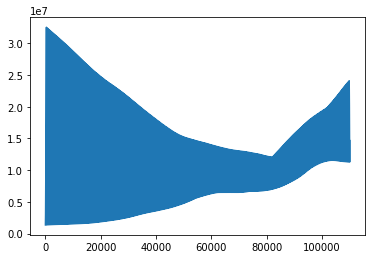

In [0]:
plt.plot(norm_pr_gfrag_sqr.ravel()) # Рисуем квадрат нормы проекции "g_frag" на "f"

In [0]:
# chi_X -- const field of vision \ "chi_X" - поле зрения постоянной яркости:
# 1 1 1 0 0 ... 0
# 1 1 1 0 0 ... 0
# 1 1 1 0 0 ... 0
# 0 0 0 0 0 ... 0
# . . .
# 0 0 0 0 0 ... 0
chi_X = np.zeros((g.size[1], g.size[0]), dtype=bool)
chi_X[:hf, :wf] = np.ones((hf, wf))

print (g_mat.min())
print ((g_mat**2).min())

# || g ||^2 \ Считаем кадрат нормы фрагмента "g" "g_frag"
fft_gsqr = np.fft.fft2(g_mat ** 2)
fft_chi_X = np.fft.fft2(chi_X)
norm_gfrag_sqr = np.fft.ifft2(fft_gsqr * fft_chi_X)[hf:, wf:].astype('float')

# norm_gfrag_sqr = abs(norm_gfrag_sqr)

1
1


/home/stan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


In [0]:
# Считаем еще квадрат нормы
norm_E_gfrag_sqr = np.fft.ifft2(fft_g * fft_chi_X)[hf:, wf:].astype('float') \
                        ** 2 / (hf * wf)

/home/stan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


173664.85506559443


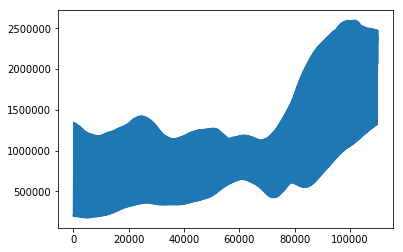

In [0]:
# Вычисляем значение числителя метрики "tau", которую нужно минимизировать для решения задачи поиска
numerator = norm_gfrag_sqr - norm_pr_gfrag_sqr
plt.plot(numerator.ravel())
print (numerator.min())

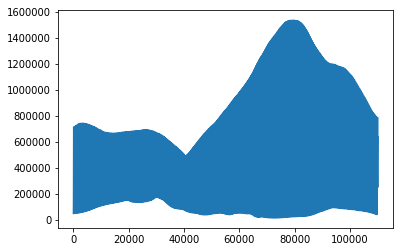

In [0]:
# Вычисляем значение знаменателя метрики "tau"
denominator = norm_pr_gfrag_sqr - norm_E_gfrag_sqr
plt.plot(denominator.ravel())

In [0]:
tau = numerator / denominator # Считаем "tau"


78170
Left: 963 2093
Right: 951 2310


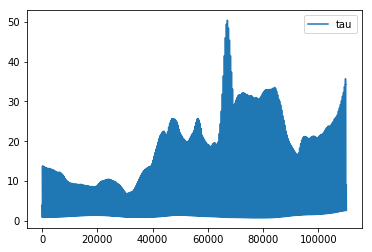

In [0]:
plt.plot(tau.ravel(), label='tau') # Рисуем "tau"
plt.legend()
idx_min = tau.argmin() # Находим индекс минимального значения "tau"
print (idx_min)

print ('Left:', yf, xf)
# Вычисляем значения координат найденного фрагмента в области "g"
y_found = idx_min // tau.shape[1] + 1
x_found = idx_min % tau.shape[1] + 1
print ('Right:', y_found + yg, x_found + xg)

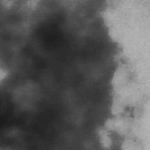

In [0]:
found_gfrag = g_mat[y_found : y_found + hf, x_found : x_found + wf]
Image.fromarray((found_gfrag * 256 / num_shades).astype('uint8'), 'L') # Рисуем найденный в области "g" фрагмент

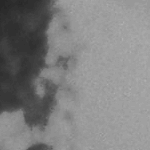

In [0]:
# Flip matrix \ Переворачиваем обратно матрицу "f"
f_mat = np.fliplr(f_mat)
f_mat = np.flipud(f_mat)

Image.fromarray((f_mat * 256 / num_shades).astype('uint8'), 'L') # Рисуем искомый фрагмент "f"

In [0]:
# result x, y -- Вычисляем координаты найденного фрагмента на правом кадре
res_y, res_x = y_found + yg, x_found + xg

In [0]:
# Calculate altitude \ Считаем высоту
x_pixel_distance = abs(res_x - xf) # Модуль дистанции по горизонтали (пикс)
viewangle = np.pi * viewangle_x / 180.0; # Угол обзора камеры (рад)
altitude = base * resolution_x / (2 * np.tan(viewangle / 2.0) * x_pixel_distance) # высота (м)
resolution_x_err = 2; # pixels \ Ошибка определения разрешения кадра по Х

# Ошибка определения дистанции (пикс)
err_distance = base_err * resolution_x / ( 2 * np.tan(viewangle / 2.0) * x_pixel_distance )

# Ошибка угла обзора
err_viewangle = (viewangle_x_err * np.pi / 180.0) * ( base * resolution_x / \
                                                   (4.0 * x_pixel_distance * (np.sin(viewangle / 2.0)) ** 2) )

# Ошибка разрешения по Х
err_resolution = resolution_x_err * base * resolution_x / \
                    ( 2 * np.tan(viewangle / 2.0) * (x_pixel_distance) ** 2 ) 

# Ошибка высоты (м)
total_error = np.sqrt( err_distance ** 2 + err_viewangle ** 2 + err_resolution ** 2 )
ratio_error = total_error * 100.0 / altitude # Относительное значение погрешности высоты


print ("Search done")
print ("Pixel distance:", x_pixel_distance)
print ("Altitude: %f +- %f meters (error is %f percent)" % (altitude, total_error, ratio_error))

Search done
Pixel distance: 217
Altitude: 200.265741 +- 20.733482 meters (error is 10.352985 percent)


In [0]:
# (For brightness-altitude correlation)
# Integral brightness of fragment === sum of all pixel values 
# in fragment
integral_brightness = f_mat.sum() # Суммарная яркость фрагмента
print ('integral_brightness:', integral_brightness)

integral_brightness: 721581


In [0]:
# Записываем результаты в конец файла "results/$ДАТА$.txt"
with open('results/' + date + '.txt', mode='a') as f:
    s = str(x_pixel_distance) + ' ' + str(altitude) + ' ' + \
        str(total_error) + ' ' + str(integral_brightness) + '\n'
    f.write(s)
    